# Load Images and Measurements

In [1]:
import csv
from os.path import isfile
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

def file_exists(file_name, img_dirs):
    for base_path in img_dirs:
        full_name = "/".join([".", base_path, file_name])
        if isfile(full_name):
            return (True, full_name)
        
    return (False, None)


def process_image_file(image_names, measurements, file_name, measurement, img_dirs):
    is_present, full_name = file_exists(file_name, img_dirs)
    if is_present:
            image_names.append(full_name)
            measurements.append(measurement)
    return is_present
    
def load_log_files():
    log_dirs = ['Simulator_Images_4', 'Simulator_Images_2', 'Simulator_Images', 'Simulator_Images_0']
    img_dirs = ["/".join([log_dir, "IMG"]) for log_dir in log_dirs]
    log_files = ["/".join([log_dir, "driving_log.csv"]) for log_dir in log_dirs]
    
    image_names = []
    measurements = []
    measurement_class = []
    angle_correction_factor = 0.05
    angle_magnification = 1.0
    
    threshold = 0
    for log_file in log_files:
        with open(log_file, 'r') as csv_file:
            filereader = csv.reader(csv_file)
            
            for row in filereader:
                if '\\' in row[0]:
                    center_file_name = row[0].split('\\')[-1]
                    left_file_name =   row[1].split('\\')[-1]
                    right_file_name =  row[2].split('\\')[-1]
                else:
                    center_file_name = row[0].split('/')[-1]
                    left_file_name =   row[1].split('/')[-1]
                    right_file_name =  row[2].split('/')[-1]
                    
                center_measurement = float(row[3]) * angle_magnification
                left_measurement =  center_measurement + angle_correction_factor
                right_measurement = center_measurement - angle_correction_factor
                                   
                if process_image_file(image_names, measurements, center_file_name, center_measurement, img_dirs):
                    threshold += 1
                    if center_measurement > 0 or center_measurement < 0:
                        measurement_class.append(1)
                    else:
                        measurement_class.append(0)
                    
                if process_image_file(image_names, measurements, left_file_name, left_measurement, img_dirs):
                    threshold += 1
                    if center_measurement > 0 or center_measurement < 0:
                        measurement_class.append(1)
                    else:
                        measurement_class.append(0)
                if process_image_file(image_names, measurements, right_file_name, right_measurement, img_dirs):
                    threshold += 1         
                    if center_measurement > 0 or center_measurement < 0:
                        measurement_class.append(1)
                    else:
                        measurement_class.append(0)
                if threshold > 180000:
                    break
        if threshold > 180000:
            break

    print ("Number of images: {}".format(len(image_names)))
    print ("Measurement classes: {}".format(len(measurement_class)))
    return (image_names, measurements, measurement_class)


def get_train_validation_data():
    image_names, image_measurements, measurement_class =  load_log_files()
    train_image_samples, validation_image_samples, train_angle_samples, validation_angle_samples = train_test_split(
         image_names, image_measurements, test_size=0.33, random_state=42, stratify=measurement_class)
    return list(zip(train_image_samples, train_angle_samples)), list(zip(validation_image_samples, validation_angle_samples))

In [2]:
import random
if random.randint(0,1):
    print ("True")
else:
    print ("False")

True


In [3]:
from sklearn.utils import shuffle
import numpy as np
import cv2
from math import ceil
import random
from skimage import exposure
from scipy import ndimage

def resize_image(img, target_width, target_height):
    num_rows = len(img[:, 0, 0])
    crop_top_rows = 50
    crop_bottom_rows = 20
    img = img[crop_top_rows:(num_rows - crop_bottom_rows), :, :]
    img = cv2.resize(img, (target_width, target_height), interpolation = cv2.INTER_CUBIC)
    return img
    
def read_image(image_path, target_width, target_height):
    img = resize_image(cv2.imread(image_path), target_width, target_height)
    return img

def sample_generator(samples, batch_size, target_width=224, target_height=64):
    num_samples = len(list(samples))
        
    while 1:
        shuffle(samples)
        for i in range(0, num_samples, batch_size):
            batch_samples = samples[i : i + batch_size]
            
            images = []
            angles = []
            for sample in batch_samples:
                do_flip = random.randint(0,1)
                do_contrast = random.randint(0,1)
                do_blur = random.randint(0,1)

                img = read_image(sample[0], target_width, target_height)
                steering_angle = float(sample[1])
                
                if do_flip:
                    img = cv2.flip(img,1)
                    steering_angle = -1.0 * steering_angle
                
                if do_blur:
                    img = ndimage.gaussian_filter(img, sigma=5)
                elif do_contrast:
                    # contrast stretch
                    low_percentile, high_percentile = np.percentile(img, (0.2, 99.8))
                    img = exposure.rescale_intensity(img, in_range=(low_percentile, high_percentile))
                    
                images.append(img)
                angles.append(steering_angle)
        
            image_set = np.array(images, dtype=np.float32)
            image_set /= 255.0
            image_set -= 0.5
            angle_set = np.array(angles, dtype=np.float32)
            
            yield shuffle(image_set, angle_set)

# Model Architecture

## VGG 19

In [4]:
train_data, val_data = get_train_validation_data()
train_sample_size = len(train_data)
val_sample_size = len(val_data)
print ("Training samples: {}".format(train_sample_size))
print ("Validation samples: {}".format(val_sample_size))

Number of images: 81166
Measurement classes: 81166
Training samples: 54381
Validation samples: 26785


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 64, 224, 3)    0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 64, 224, 64)   1792        input_2[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 64, 224, 64)   36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 32, 112, 64)   0           block1_conv2[0][0]               
___________________________________________________________________________________________

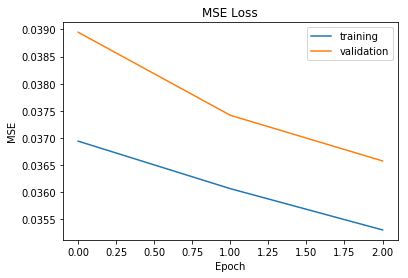

In [7]:
### Reference: https://github.com/fchollet/keras/blob/master/keras/applications/vgg19.py

from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.applications.vgg19 import VGG19
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
%matplotlib inline

model_save_file='model-{epoch:02d}-{val_loss:.4f}.h5'
saved_model_file='model-06-0.0336.h5'
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(64, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.get_layer('block5_pool').output
x = Flatten(name='custom_flatten')(x)
x = Dense(4096, activation='relu', name='custom_fc1')(x)
x = Dropout(0.5)(x)
x = Dense(2048, activation='relu', name='custom_fc2')(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu', name='custom_fc3')(x)
predictions = Dense(1, activation='linear', name='custom_predictions')(x)

model = Model(input=base_model.input, output=predictions)
model.load_weights(saved_model_file)
print (model.summary())

batch_size=32
train_generator = sample_generator(train_data, batch_size = batch_size)
validation_generator = sample_generator(val_data, batch_size = batch_size)

opt = Adam(lr=0.001, beta_1=0.9)
model.compile(loss='mse', optimizer=opt)
early_stopper = EarlyStopping(monitor='loss', min_delta=1e-5)
checkpointer = ModelCheckpoint(filepath=model_save_file, save_best_only=False)
hist = model.fit_generator(train_generator, samples_per_epoch = train_sample_size, nb_epoch=3, verbose=1,
                           validation_data=validation_generator, nb_val_samples = val_sample_size,
                          callbacks = [early_stopper, checkpointer])

### plt the training and validation loss for each epoch
plt.figure(1)
loss_plot = plt.subplot(1,1,1)
loss_plot.set_title("MSE Loss")
loss_plot.plot(hist.history['loss'], label='training')
loss_plot.plot(hist.history['val_loss'], label='validation')
loss_plot.set_ylabel('MSE')
loss_plot.set_xlabel('Epoch')
loss_plot.legend(loc = 'upper right')
plt.show()

## Test sample predictions

In [6]:
from keras.models import load_model
import random
#model = load_model("model_vgg_201708091340.h5")

x_p = []
y_a = []
for i in range(0, 10):
    idx = random.randint(0, len(train_data) - 1)
    sample = train_data[idx]
    img = read_image(sample[0], 224, 64)
    x_p.append(img)
    y_a.append(float(sample[1]))

image_set = np.array(x_p, dtype=np.float32)
image_set /= 255.0
image_set -= .5

predictions = model.predict(image_set)
predictions /= 1.0
y_a = [y/1.0 for y in y_a]
print ("Predictions: {}".format(predictions))
print ("Actual: ")
for y in y_a:
    print (y)

Predictions: [[ 0.04590516]
 [ 0.06430312]
 [-0.09563462]
 [-0.02286803]
 [ 0.00201762]
 [ 0.06069273]
 [ 0.02904044]
 [-0.08423737]
 [-0.00224839]
 [-0.01546585]]
Actual: 
0.09262284000000001
0.11008584
-0.2401408
-0.2060086
-0.027464790000000003
0.05
0.0
0.0
-0.05
-0.05
